In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mkdir '/content/gdrive/My Drive/dataset'

In [0]:
path = '/content/gdrive/My Drive/dataset/text8'
with  open(path) as ft_:
  full_text = ft_.read()
  


In [0]:
def  text_processing(ft8_text):
  '''
  替换掉标点符号
  '''
  ft8_text = ft8_text.lower()
  ft8_text = ft8_text.replace('.', '<period>')
  ft8_text = ft8_text.replace(',', '<comma>')
  ft8_text = ft8_text.replace('"', '<quotation>')
  ft8_text = ft8_text.replace(';', '<semicolon>')
  ft8_text = ft8_text.replace('!', '<exclamation>')
  ft8_text = ft8_text.replace('?', '<question>')
  ft8_text = ft8_text.replace('(', '<paren_l>')
  ft8_text = ft8_text.replace(')', '<paren_r>')
  ft8_text = ft8_text.replace('--', '<hyphen>')
  ft8_text = ft8_text.replace(':', '<colon>')
  ft8_text_tokens = ft8_text.split()
  return ft8_text_tokens

ft_tokens = text_processing(full_text)

In [0]:
import random
import collections
import math
import time
import re
import numpy as np

word_cnt = collections.Counter(ft_tokens)
shortlisted_words = [w for w in ft_tokens if word_cnt[w] > 7]
print(shortlisted_words[:15])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including']


In [0]:
def  dict_creation(shortlisted_words):
  '''
  建立起单词和它出现频率之间的对应关系
  '''
  counts = collections.Counter(shortlisted_words)
  '''
  #将单词按出现次数由高到低排序，例如"the"出现最多就排第一位，它的序号为0，“an”次数第二多，序号
  对应为1,单词序号很重要，后面会用来建立单词的one-hot-vector，也就是把单词序号下标在向量中设置为1
  '''
  vocabulary = sorted(counts, key=counts.get, reverse=True)
  #将单词序号映射到单词
  rev_dictionary_ = {ii:word for ii, word in enumerate(vocabulary)}
  #将单词映射到序号,
  dictionary_ = {word: ii for ii, word in rev_dictionary_.items()}
  return dictionary_, rev_dictionary_

dictionary_, rev_dictionary_ = dict_creation(shortlisted_words)    
words_cnt = [dictionary_[word] for word in shortlisted_words]


In [0]:
'''
根据负采样公式，把频率过低的单词过滤掉
'''
thresh = 0.00005
'''
建立单词序号与它出现次数的映射关系
'''
word_counts = collections.Counter(words_cnt)
total_count = len(words_cnt)
#建立单词与出现频率的对应关系
freqs = {word: count / total_count for word, count in word_counts.items()}
#根据负采样公式过滤单词
p_drop = { word: 1 - np.sqrt(thresh / freqs[word]) for word in word_counts}
train_words = [word for word in words_cnt if p_drop[word] < random.random()]

In [0]:
def  skipG_target_set_generation(batch_, batch_index, word_window):
  '''
  根据表12-1的方式构造网络训练数据
  '''
  random_num = np.random.randint(1, word_window + 1)
  #选择中心词左边窗口范围内的单词
  words_start = batch_index - random_num if (batch_index - random_num) > 0 else 0
  #选择中心词右边窗口范围内单词
  words_stop = batch_index + random_num
  window_target = set(batch_[words_start:batch_index] + batch_[batch_index+1 :
                                                               words_stop+1])
  return list(window_target)

def  skipG_batch_creation(short_words, batch_length, word_window):
  #将训练单词分批
  batch_cnt = len(short_words) // batch_length
  short_words = short_words[:batch_cnt * batch_length]
  
  for word_index in range(0, len(short_words), batch_length):
    #input_words是中心词
    #label_words 是中心词左右两边窗口范围内的单词
    input_words, label_words = [], []
    word_batch = short_words[word_index: word_index + batch_length]
    for index_ in range(len(word_batch)):
      batch_input = word_batch[index_]
      batch_label = skipG_target_set_generation(word_batch, index_, word_window)
      label_words.extend(batch_label)
      input_words.extend([batch_input] * len(batch_label))
      '''
      给定句子 ’the cat jump over the dog',窗口范围2，如果中心词是jump那么输出格式为
      input_words = [jump ,jump ,jump ,jump]
      label_words = [the, cat, over, the]
      '''
    yield input_words, label_words

In [0]:
import tensorflow as tf

tf_graph = tf.Graph()
with tf_graph.as_default():
  input_ = tf.placeholder(tf.int32, [None], name='input_')
  label_ = tf.placeholder(tf.int32, [None, None], name='label_')
  #构建中间二维向量
  word_embed = tf.Variable(tf.random_uniform((len(rev_dictionary_), 300), -1, 1))
  #计算one-hot-vector与中间向量乘机,其实就是把二维向量指定行选取出来
  embedding = tf.nn.embedding_lookup(word_embed, input_)
  
  vocabulary_size = len(rev_dictionary_)
  
  #添加中间层和输出层之间的链路参数,并使用正太分布对参数进行初始化
  sf_weights = tf.Variable(tf.truncated_normal((vocabulary_size, 300), stddev=0.1))
  sf_bias = tf.Variable(tf.zeros(vocabulary_size))
  '''
  使用梯度下降法训练参数，我们不训练所有参数而是随机选取第三层100个节点对应的链路参数进行修正,
  由于每个节点对应300个链路参数，因此总共修正的有(100+1)*300个参数
  '''
  loss_fn = tf.nn.sampled_softmax_loss(weights=sf_weights,
                                      biases=sf_bias,
                                      labels=label_,
                                      inputs=embedding,
                                      num_sampled=100,
                                      num_classes=vocabulary_size,
                                      )
  cost_fn = tf.reduce_mean(loss_fn)
  optim = tf.train.AdamOptimizer().minimize(cost_fn)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [0]:
'''
使用余弦公式计算两个单词向量的距离，通过距离的大小展示单词含义是否相近
'''
with tf_graph.as_default():
  validation_cnt = 16
  validation_dict = 100
  
  #从编号为0到100的单词中随机选出8个
  validation_words = np.array(random.sample(range(validation_dict), validation_cnt//2))
  #再从编号为1000到1100的单词随机选出8个
  validation_words = np.append(validation_words, random.sample(range(1000,
                                                                    1000+validation_cnt),
                                                              validation_cnt//2))
  validation_data = tf.constant(validation_words, dtype=tf.int32)
  #先对单词向量做归一化处理
  normalization_embed = word_embed / (tf.sqrt(tf.reduce_sum(tf.square(word_embed), 
                                                            1, keep_dims = True)))
  #将单词对应的向量挑选出来
  validation_embed = tf.nn.embedding_lookup(normalization_embed, validation_data)
  #计算两个向量内积，所得结果就是向量间距离
  word_similarity = tf.matmul(validation_embed, tf.transpose(normalization_embed))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
#循环训练10次，由于训练过程非常耗时，如果没有GPU，在训练时可以尝试把该值变小
epochs = 2
batch_length = 1000
word_window = 10

with tf_graph.as_default():
  saver = tf.train.Saver()
  
with tf.Session(graph = tf_graph) as sess:
  iteration = 1
  loss = 0
  sess.run(tf.global_variables_initializer())
  
  for e in range(1, epochs + 1):
    batches = skipG_batch_creation(train_words, batch_length, word_window)
    start = time.time()
    
    
    for x, y in batches:
      train_loss, _ = sess.run([cost_fn, optim], feed_dict={input_: x,
                                                           label_: np.array(y)[:, None]})
      loss += train_loss
      if iteration % 100 == 0:
        end = time.time()
        print("Epoch {}/{}".format(e, epochs), ", Iteration: {}".format(iteration),
             ", Avg Training loss: {:.4f}".format(loss/100),
             ", Procession: {:.4f} sec/batch".format((end - start) / 100))
        loss = 0
        start = time.time()
      #迭代训练2000次后计算一下单词相似度
      if iteration % 2000 == 0:
        similarity_ = word_similarity.eval()
        for i in range(validation_cnt):
          validated_words = rev_dictionary_[validation_words[i]]
          #根据计算距离，找出与当前单词距离最短的8个词
          top_k = 8
          nearest = (-similarity_[i, :]).argsort()[1: top_k+1]
          log = "Nearest to %s:" % validated_words
          for k in range(top_k):
            close_word =rev_dictionary_[nearest[k]]
            log = '%s %s,' % (log, close_word)
          print(log)
          
      iteration += 1
      
  path = '/content/gdrive/My Drive/skipGram_text8.ckpt'
  save_path = saver.save(sess, path)
  embed_mat = sess.run(normalization_embed)

Epoch 1/2 , Iteration: 100 , Avg Training loss: 6.1691 , Procession: 0.0379 sec/batch
Epoch 1/2 , Iteration: 200 , Avg Training loss: 6.1191 , Procession: 0.0350 sec/batch
Epoch 1/2 , Iteration: 300 , Avg Training loss: 6.0809 , Procession: 0.0348 sec/batch
Epoch 1/2 , Iteration: 400 , Avg Training loss: 6.0179 , Procession: 0.0350 sec/batch
Epoch 1/2 , Iteration: 500 , Avg Training loss: 5.9354 , Procession: 0.0350 sec/batch
Epoch 1/2 , Iteration: 600 , Avg Training loss: 5.9745 , Procession: 0.0350 sec/batch
Epoch 1/2 , Iteration: 700 , Avg Training loss: 5.8677 , Procession: 0.0348 sec/batch
Epoch 1/2 , Iteration: 800 , Avg Training loss: 5.7453 , Procession: 0.0352 sec/batch
Epoch 1/2 , Iteration: 900 , Avg Training loss: 5.6843 , Procession: 0.0349 sec/batch
Epoch 1/2 , Iteration: 1000 , Avg Training loss: 5.5634 , Procession: 0.0346 sec/batch
Epoch 1/2 , Iteration: 1100 , Avg Training loss: 5.4524 , Procession: 0.0348 sec/batch
Epoch 1/2 , Iteration: 1200 , Avg Training loss: 5.4

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/skipGram_text8_epoch10.ckpt


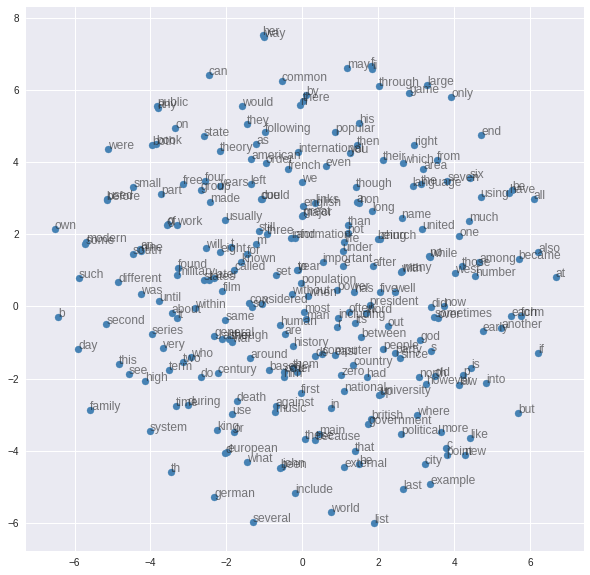

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

with tf.Session(graph=tf_graph) as sess:
  path = '/content/gdrive/My Drive/skipGram_text8_epoch10.ckpt'
  saver = tf.train.import_meta_graph(path + '.meta')
  #将训练后存储成文件的网络参数重新加载
  saver.restore(sess, path)
  sess.run(tf.global_variables_initializer())
  embed_mat = sess.run(word_embed)
  #选取250个单词向量在二维平面上展示
  word_graph = 250
  tsne = TSNE()
  word_embedding = tsne.fit_transform(embed_mat[:word_graph,:])
  fig, ax = plt.subplots(figsize=(10, 10))
  for idx in range(word_graph):
    plt.scatter(*word_embedding[idx, :], color='steelblue')
    plt.annotate(rev_dictionary_[idx], (word_embedding[idx, 0], word_embedding[idx, 1]), alpha=0.6)


In [0]:
!pip install utils

In [0]:
!pip install sklearn

In [0]:
!mkdir '/content/gdrive/My Drive/movie review'
!mkdir '/content/gdrive/My Drive/movie review/good/'
!mkdir '/content/gdrive/My Drive/movie review/bad/'

In [0]:
from utils import *
import tensorflow as tf
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
import time
import re
import numpy as np

def clearstring(string):
  #只选择包含字母和数字的字符串
  string = re.sub('[^A-Za-z0-9]+', ' ', string)
  #把句子分割成多个单词合成的队列
  string = string.split(' ')
  string = filter(None, string)
  #消除单词首尾空格
  string = [y.strip() for y in string] 
  string = ' '.join(string)

  return string.lower()

def  seperate_dataset(trainset, ratio=0.5):
  '''
  把文本中语句一条条分隔开，并打上标签
  '''
  text = []
  label = []
  for i in range(int(len(trainset.data) * ratio)):
    #把文本分割成多个句子
    data_ = trainset.data[i].split('\n')
    #过滤掉空行
    data_ = list(filter(None, data_))
    for n in range(len(data_)):
      #去掉句子中不符合规则的单词
      data_[n] = clearstring(data_[n])
    text += data_
    for n in range(len(data_)):
      #打上标签，因为目录下只有两个文件夹因此只有两种标签
      label.append(trainset.target[i])
  return text, label


In [0]:


s = ' this is 98 !@# *q'
s = clearstring(s)
print(s)

this is 98 q


In [0]:
path = '/content/gdrive/My Drive/movie review'
trainset = sklearn.datasets.load_files(container_path = path, encoding = 'UTF-8')

'''
将文本中的句子抽取出来，形成两个集合，由于文件夹下只有两个子文件夹
因此它们对应两个标签
'''
trainset.data, trainset.target = seperate_dataset(trainset, 1.0)
print(trainset.target_names)
print('training data has {0} items'.format(len(trainset.data)))


['bad', 'good']
training data has 10662 items


In [0]:
#为每条记录附带两个标志位
onehot = np.zeros((len(trainset.data), len(trainset.target_names)))
#属于bad目录下的句子对应标签[1,0],属于good目录下的句子附带标签[0,1]
onehot[np.arange(len(trainset.data)), trainset.target] = 1.0
'''
将trainset.data, trianset.target, onehot三个数组以8:2的方式分成两部分
一部分用于测试
'''
train_X, test_X, train_Y, test_Y, train_onehot,test_onehot = train_test_split(trainset.data, trainset.target, onehot, test_size = 0.2)

concat = ' '.join(trainset.data).split()
vocabulary_size = len(list(set(concat)))
print(vocabulary_size)


NameError: ignored

In [0]:
print(train_onehot[0])

[1. 0.]


In [0]:
import collections

def  build_dataset(words, n_words):
  '''
  将文本中的单词拆解成字典
  '''
  count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
  #统计每个单词的出现次数,我们只选出现次数在前n_words范围内的单词
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    #给每个单词进行编号,编号会从4开始
    dictionary[word] = len(dictionary)
    
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    #统计没有被选入范围的单词
    if index == 0:
      unk_count += 1
    data.append(index)
  
  count[0][1] = unk_count
  #把编号和单词对应关系对换
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary
      

In [0]:
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)

print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])

NameError: ignored

In [0]:
'''
网络分两层，第一层128个节点，第二层也是128个节点，
'''
size_layer = 128
num_layers = 2
embedded_size = 128
dimension_output = len(trainset.target_names)
learning_rate = 1e-3
maxlen = 50
batch_size = 128

class RNN:
  def __init__(self, size_layer, num_layer, embedded_size, dict_size,
              dimension_output, learning_rate):
    def  cells(reuse = False):
      '''
      tensorflow封装了RNN节点，它跟我们前面描述的能在内部记录当前输入数据处理信息，
      并将信息传递到下一次数据处理的R节点一样
      '''
      return tf.nn.rnn_cell.BasicRNNCell(size_layer, reuse=reuse)
    #定义输入数据变量
    self.X = tf.placeholder(tf.int32, [None, None])
    #定义输出数据变量
    self.Y = tf.placeholder(tf.float32, [None, dimension_output])
    '''
    定义embedding层，这一层与我们前面讲单词向量训练时提到过的网络第一层一样，它对应
    一个二维矩阵，矩阵的每一行表示单词向量,self.X是one-hont-vector,它会将矩阵的某一行
    挑选出来
    '''
    embeddings = tf.Variable(tf.random_uniform([dict_size, embedded_size], -1, 1))
    embedded = tf.nn.embedding_lookup(embeddings, self.X)
    #串联两个RNN节点增强识别能力
    rnn_cells = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)])
    #根据输入数据长度构造相应数量RNN节点，形成RNN网络层
    outputs, _ = tf.nn.dynamic_rnn(rnn_cells, embedded, dtype=tf.float32)
    #将RNN网络层输出的含有128个分量的向量转换为只有2个分量的向量
    W = tf.get_variable('w', shape=(size_layer, dimension_output),
                       initializer=tf.orthogonal_initializer())
    b = tf.get_variable('b', shape=(dimension_output), initializer=tf.zeros_initializer())
    #将两个分量重，数值较大的那个当做当前语句所属分类
    self.logits = tf.matmul(outputs[:, -1], W) + b
    self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits,
                                                                labels=self.Y))
    self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)
    
    
    correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
    self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [0]:
'''
网络分两层，第一层128个节点，第二层也是128个节点，
'''
size_layer = 128
num_layers = 2
embedded_size = 128
dimension_output = len(trainset.target_names)
learning_rate = 1e-3
maxlen = 50
batch_size = 128

class RNN:
  def __init__(self, size_layer, num_layer, embedded_size, dict_size,
              dimension_output, learning_rate):
    def  cells(reuse = False):
      '''
      tensorflow封装了RNN节点，它跟我们前面描述的能在内部记录当前输入数据处理信息，
      并将信息传递到下一次数据处理的R节点一样
      '''
      return tf.nn.rnn_cell.LSTMCell(size_layer, reuse=reuse)
    #定义输入数据变量
    self.X = tf.placeholder(tf.int32, [None, None])
    #定义输出数据变量
    self.Y = tf.placeholder(tf.float32, [None, dimension_output])
    '''
    定义embedding层，这一层与我们前面讲单词向量训练时提到过的网络第一层一样，它对应
    一个二维矩阵，矩阵的每一行表示单词向量,self.X是one-hont-vector,它会将矩阵的某一行
    挑选出来
    '''
    embeddings = tf.Variable(tf.random_uniform([dict_size, embedded_size], -1, 1))
    embedded = tf.nn.embedding_lookup(embeddings, self.X)
    #串联两个RNN节点增强识别能力
    rnn_cells = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)])
    #根据输入数据长度构造相应数量RNN节点，形成RNN网络层
    outputs, _ = tf.nn.dynamic_rnn(rnn_cells, embedded, dtype=tf.float32)
    #将RNN网络层输出的含有128个分量的向量转换为只有2个分量的向量
    W = tf.get_variable('w', shape=(size_layer, dimension_output),
                       initializer=tf.orthogonal_initializer())
    b = tf.get_variable('b', shape=(dimension_output), initializer=tf.zeros_initializer())
    #将两个分量重，数值较大的那个当做当前语句所属分类
    self.logits = tf.matmul(outputs[:, -1], W) + b
    self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits,
                                                                labels=self.Y))
    self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)
    
    
    correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
    self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [0]:
'''
将输入语句中的单词转换成对应编号
'''
def  word_to_index(corpus, dic, maxlen, UNK=3):
  X = np.zeros((len(corpus), maxlen))
  for i in range(len(corpus)):
    '''
    规定一句话单词量不能超过maxlen，超过了就截断。然后从最后一个单词开始，到第一个单词，
    将每个单词转换为对应编号
    '''
    for no, k in enumerate(corpus[i].split()[:maxlen][::-1]):
      try:
        X[i, -1 - no] = dic[k]
      except:
        X[i, -1 - no] = UNK
      
  return X

s = []
s.append("the rock is destined to be")
x = word_to_index(s, dictionary, maxlen)
print(x)

[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.    4.  645.    9. 2540.
     8.   22.]]


In [0]:
import time

tf.reset_default_graph()
sess = tf.InteractiveSession()
rnn = RNN(size_layer, num_layers, embedded_size, vocabulary_size+4, dimension_output,
         learning_rate)
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver(tf.global_variables(), max_to_keep=2)
checkpint_dir =  '/content/gdrive/My Drive/dataset/checkpoints_basci_rnn'

EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 30, 0, 0, 0
while True:
  lasttime = time.time()
  if CURRENT_CHECKPOINT == EARLY_STOPPING:
    print('break epoch: %d\n' % (EPOCH))
    break
    
  train_acc, train_loss, test_acc,test_loss = 0,0,0,0
  #训练网络
  for i in range(0, (len(train_X) // batch_size) * batch_size, batch_size):
    batch_x = word_to_index(train_X[i : i + batch_size], dictionary, maxlen)
    acc, loss, _ = sess.run([rnn.accuracy, rnn.cost, rnn.optimizer], 
                            feed_dict = {rnn.X: batch_x,
                                         rnn.Y: train_onehot[i : i + batch_size]})
    train_loss += loss
    train_acc += acc
  
  #检测训练结果
  for i in range(0, (len(test_X) // batch_size) * batch_size, batch_size):
    batch_x = word_to_index(test_X[i : i + batch_size], dictionary, batch_size)
    acc, loss = sess.run([rnn.accuracy, rnn.cost],
                        feed_dict = {rnn.X : batch_x,
                                            
                                    rnn.Y : test_onehot[i : i + batch_size]})
    test_loss += loss
    test_acc += acc
  
  train_loss /= (len(train_X) // batch_size)
  train_acc /= (len(train_X) // batch_size)
  test_loss /= (len(test_X) // batch_size)
  test_acc /= (len(test_X) // batch_size)
  
  if test_acc > CURRENT_ACC:
    print('epoch: %d, pass acc: %f, current acc %f' % (EPOCH, CURRENT_ACC, test_acc))
    CURRENT_ACC = test_acc
    CURRENT_CHECKPOINT = 0
  else:
    CURRENT_CHECKPOINT += 1
  
  print('time taken: ', time.time() - lasttime)
  print('epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n' % (EPOCH, 
                                                                                             train_loss, 
                                                                                            train_acc, test_loss,
                                                                                            test_acc))
  path = saver.save(sess, checkpint_dir, global_step = EPOCH)
  EPOCH += 1
  
  

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

epoch: 0, pass acc: 0.000000, current acc 0.618652
time taken:  7.767234802246094
epoch: 0, training loss: 0.671953, training acc: 0.575758, valid loss: 0.642627, valid acc: 0.618652

epoch: 1, pass acc: 0.618652, current acc 0.686523
time taken:  7.028607606887817
epoch: 1, training loss: 0.573840, training acc: 0.694957, valid loss: 0.602087, valid acc: 0.686523

epoch: 2, pass acc: 0.686523, current acc 0.709961
time taken:  7.2615602016448975
epoch: 2, training loss: 0.434170, training acc: 0.797940, valid loss: 0.597988, valid acc: 0.709961

epoch: 3, pass acc: 0.709961, current acc 0.729492
time taken:  7.1144936084747314
epoch: 3, training loss: 0.297450, training acc: 0.873816, valid loss: 0.642368, valid acc: 0.729492

time taken:  7.101795434951782
epoch: 4, training loss: 0.210415, train

In [0]:
!mkdir '/content/gdrive/My Drive/conversation'

In [0]:
'''
将文本句子分解成单词，并构建词库
'''

path = '/content/gdrive/My Drive/conversation/'
with open(path + 'question.txt', 'r') as fopen:
  text_question = fopen.read().lower().split('\n')
with open(path + 'answer.txt', 'r') as fopen:
  text_answer = fopen.read().lower().split('\n')
  
concat_question = ' '.join(text_question).split()
vocabulary_size_question = len(list(set(concat_question)))
data_question, count_question, dictionary_question, rev_dictionary_question = build_dataset(concat_question, 
                                                                                         vocabulary_size_question)
print('vocab question size: %d' %(vocabulary_size_question))
#前4个单词有控制功能，具有含义的单词从编号4开始
print('Most common words:', count_question[4:10])
print('Sample data: ', data_question[:10], [rev_dictionary_question[i] for i in data_question[:10]])

path = '/content/gdrive/My Drive/conversation/'
with open(path + 'question.txt', 'r') as fopen:
  text_question = fopen.read().lower().split('\n')
with open(path + 'answer.txt', 'r') as fopen:
  text_answer = fopen.read().lower().split('\n')
  
concat_answer = ' '.join(text_answer).split()
vocabulary_size_answer = len(list(set(concat_answer)))
data_answer, count_answer, dictionary_answer, rev_dictionary_answer = build_dataset(concat_answer, 
                                                                                         vocabulary_size_answer)
print('vocab answer size: %d' %(vocabulary_size_answer))
#前4个单词有控制功能，具有含义的单词从编号4开始
print('Most common words:', count_answer[4:10])
print('Sample data: ', data_answer[:10], [rev_dictionary_answer[i] for i in data_answer[:10]])

l = [dictionary_question['how'], dictionary_question['are'], dictionary_question['you']]
print(l)
l = [dictionary_answer['i'],dictionary_answer['am'], dictionary_answer['fine']]
print(l)


vocab question size: 331
Most common words: [('you', 73), ('is', 67), ('what', 63), ('a', 49), ('the', 40), ('do', 36)]
Sample data:  [82, 54, 142, 54, 143, 54, 144, 54, 145, 11] ['hi', 'good', 'morning', 'good', 'afternoon', 'good', 'evening', 'good', 'night', 'how']
vocab answer size: 504
Most common words: [('i', 127), ('you', 55), ('a', 47), ('to', 44), ('the', 40), ('it', 38)]
Sample data:  [142, 105, 34, 214, 34, 215, 34, 216, 34, 217] ['hi', 'there', 'good', 'morning', 'good', 'afternoon', 'good', 'evening', 'good', 'night']
[11, 10, 4]
[4, 10, 106]


In [0]:
GO = dictionary_question['GO']
PAD = dictionary_question['PAD']
EOS = dictionary_question['EOS']
UNK = dictionary_question['UNK']

import tensorflow as tf

In [0]:
'''
tf.strided_slice(input, begin, end, stride), 对向量进行切片begin表示切片的起始位置，
end-1为切片的结束位置
'''
data = [1,2,3,4,5,6,7,8]
#从下标0开始到下标为5的元素作为切片，每隔一个元素切一刀
x = tf.strided_slice(data, [0], [6], [1])
with tf.Session() as sess:
  print('begin: 0, end: 6, stride: 1: ', sess.run(x))
#从0开始到下标为5的元素范围内，每隔两个元素切一刀
x = tf.strided_slice(data, [0], [6], [2])
with tf.Session() as sess:
  print('begin: 0, end: 6, stride: 2: ', sess.run(x))
#end可以是负数，表示倒数第几个元素，例如-1表示最后一个元素，-2表示倒数第二个元素
x = tf.strided_slice(data, [2], [-2], [1])
with tf.Session() as sess:
  print('begin:2, end 6, stride: 1: ', sess.run(x))

begin: 0, end: 6, stride: 1:  [1 2 3 4 5 6]
begin: 0, end: 6, stride: 2:  [1 3 5]
begin:2, end 6, stride: 1:  [3 4 5 6]


In [0]:
'''
tf.strided_slice如果对高维向量进行切片时，begin, end, stride要对应向量的维度,
如果我们想把最后一列从多维向量中去除，可以运行如下代码，
'''
data = [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]

batch_size = len(data[0])
print('batch_size: ', batch_size)
x = tf.strided_slice(data, [0,0], [batch_size, -1], [1, 1])
with tf.Session() as sess:
  print('begin: [0, 0], end: [batch_size, -1], stride: [1,1]: ', sess.run(x))

batch_size:  3
begin: [0, 0], end: [batch_size, -1], stride: [1,1]:  [[1 2]
 [4 5]
 [7 8]]


In [0]:
x = tf.concat([tf.fill([batch_size, 2], GO), data], 1)
with tf.Session() as sess:
  print('concat and fill', sess.run(x))

concat and fill [[0 0 1 2 3]
 [0 0 4 5 6]
 [0 0 7 8 9]]


In [0]:
max_value = tf.reduce_max([1,3,2])
mask = tf.sequence_mask([1,3,2], max_value, dtype=tf.float32)
with tf.Session() as sess:
  print('mask: ', sess.run(mask))

mask:  [[1. 0. 0.]
 [1. 1. 1.]
 [1. 1. 0.]]


In [0]:
class sequence2sequence:
  def  __init__(self, size_layer, num_layers, embedded_size, question_dict_size, 
               answer_dict_size, learning_rate, batch_size):
    def  cells(reuse = False):
      return tf.nn.rnn_cell.LSTMCell(size_layer, initializer=tf.orthogonal_initializer(),
                                    reuse = reuse)
    
    self.X = tf.placeholder(tf.int32, [None, None])
    self.Y = tf.placeholder(tf.int32, [None, None])
    self.X_seq_len = tf.placeholder(tf.int32, [None])
    self.Y_seq_len = tf.placeholder(tf.int32, [None])
    
    #构造图12-22所示的embedding层
    with tf.variable_scope('encoder_embeddings'):
      #embedding层是二维矩阵，行数对应问题文本的单词格式，列数有程序指定
      encoder_embeddings = tf.Variable(tf.random_uniform([question_dict_size,
                                                         embedded_size], -1, 1))
      #self.X包含句子每个单词的编号,网络根据编号从矩阵中挑选出对应的行
      encoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.X)
      #去掉最后一列，因为最后一个单词对应的是一个EOS控制符而不是有意义的单词
      main = tf.strided_slice(self.X, [0,0], [batch_size, -1], [1, 1])
    
    with tf.variable_scope('decoder_embeddings'):
      '''
      在main向量前面增加一列，用GO对应的值来填充，假设
      main = [ [1,2,3],
               [4,5,6],
               [7,8,9]]
      下面一行代码执行后，main会变成
      main = [ [0,1,2,3],
               [0,4,5,6],
               [0,7,8,9]]
      '''
      decoder_input = tf.concat([tf.fill([batch_size, 1], GO), main], 1)
      decoder_embeddings = tf.Variable(tf.random_uniform([answer_dict_size, embedded_size], -1, 1))
      decoder_embedded = tf.nn.embedding_lookup(decoder_embeddings, decoder_input)
      
    with tf.variable_scope('encoder'):
      #将两个LSTM节点串联起来
      rnn_cells = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)])
      _, last_state = tf.nn.dynamic_rnn(rnn_cells, encoder_embedded, dtype = tf.float32)
    with tf.variable_scope('decoder'):
      rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)])
      #把encoder部分LSTM网络输出的最终状态当做decoder部分的LSTM网络的初始状态
      outputs, _ = tf.nn.dynamic_rnn(rnn_cells_dec, decoder_embedded,
                                    initial_state = last_state,
                                    dtype = tf.float32)
      
    
    '''
      这里需要注意，假设self.X对应第一个句子是'how are your',self.Y对应的第一个句子是答案：'i am fine'，
      后者转换为编号后的向量[4，10， 106]，由于每个句子对应向量含有50个分量，
      那么不足50个单词的句子对应的向量会用控制符PAD的值进行填充，于是向量变为[4,6,106,1,1....1]
      也就是后面47个分量用1来填充,
      
      经过调用tf.sequence_mask后，会产生一个标志位向量[True, True, True, True,....True],
      于是当向量输入到网络时，sequence_loss就会查看targets参数对应向量中的50个分量，其他分量
      不看，由于答案文本中单词数可能很多，因此网络只考虑向量中对应的50个分量对应的节点进行更新，这样能有效
      降低运算量
      
      它在内部构造一个长度与answer_dict_size相同的内部向量，由于答案文本包含504个单词，因此
      网络构造内部向量的长度为504，他把所有分量的值设置为0，根据填充后向量为[4,6,106,1,1....1]，
      它把下标为4，6，106，1这4个下标对应分量设置为1
      
      然后与网络的输出层做差值运算，将运算结果反向传播后，使用梯度下降法调节参数，使得网络输出最后
      结果中，下标为4，6，106，1这四个节点的值尽可能接近1，这意味着我们在调教网络看到输入语句是
      'how are you'时，它懂得回答'i am fine'
    '''
    with tf.variable_scope('logits'):
      self.logits = tf.layers.dense(outputs, answer_dict_size)
      print(self.logits)
      masks = tf.sequence_mask(self.Y_seq_len, tf.reduce_max(self.Y_seq_len), dtype = tf.float32)
      
    with tf.variable_scope('cost'):
      self.cost = tf.contrib.seq2seq.sequence_loss(logits = self.logits,
                                                  targets = self.Y
                                                  ,weights = masks)
    with tf.variable_scope('optimizer'):
      self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)

In [0]:
#将单词转换为编号
def  str_idx(corpus, dic):
  X = []
  for i in corpus:
    ints = []
    for k in i.split():
      try:
        ints.append(dic[k])
      except Exception as e:
        print(e)
        #2表示句子的结束
        ints.append(2)
        
    X.append(ints)
  return X

'''
填充句子向量，当我们把句子单词转换为编号存储为向量时，规定向量的最大长度是50，如果句子单词不足50个
后面就用控制字符PAD填充，例如'how are you' 转换为编号时是11，10，4，填充后为11,10,4,1,1,1...1总共50个元素
'''
def  pad_sentence_batch(sentence_batch, pad_int):
  padded_seqs = []
  seq_lens = []
  max_sentence_len = 50
  for sentence in sentence_batch:
    padded_seqs.append(sentence + [pad_int] * (max_sentence_len - len(sentence)))
    seq_lens.append(50)
  return padded_seqs, seq_lens

def  check_accuracy(logits, Y):
  '''
  logits是网络预测结果,Y是正确结果,我们将网络预测结果与正确结果的契合程度
  作为网络预测准确性的判断
  '''
  acc = 0
  for i in range(logits.shape[0]):
    internal_acc = 0
    for k in range(len(Y[i])):
      if Y[i][k] == logits[i][k]:
        internal_acc += 1
    acc += (internal_acc / len(Y[i]))
    
  return acc / logits.shape[0]

In [0]:
import tensorflow as tf
import os
#LSTM节点输出向量长度
size_layer = 128
#每个MultiRNNCell含有的LSTM节点个数
num_layers = 2
#一个单词对应的向量长度
embedded_size = 128
learning_rate = 0.001
batch_size = 32
epoch = 500

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = sequence2sequence(size_layer, num_layers, embedded_size, vocabulary_size_question + 4,
                         vocabulary_size_answer + 4, learning_rate, batch_size)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables(), max_to_keep = 2)
checkpoint_dir = os.path.abspath(os.path.join('/content/gdrive/My Drive/', 'checkpoints_chatbot'))
checkpoint_prefix = os.path.join(checkpoint_dir, "model")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Tensor("logits/dense/BiasAdd:0", shape=(32, ?, 508), dtype=float32)


In [0]:

X = str_idx(text_question, dictionary_question)
Y = str_idx(text_answer, dictionary_answer)


for i in range(epoch):
  total_loss, total_accuracy = 0, 0
  for k in range(0, (len(text_question) // batch_size) * batch_size, batch_size):
    batch_x, seq_x = pad_sentence_batch(X[k : k + batch_size], PAD)
    batch_y, seq_y = pad_sentence_batch(Y[k : k + batch_size], PAD)
    
   
    predicted, loss, _ = sess.run([tf.argmax(model.logits, 2), model.cost,
                                  model.optimizer], feed_dict = {
        model.X : batch_x,
        model.Y : batch_y,
        model.X_seq_len : seq_x,
        model.Y_seq_len : seq_y
    })
    total_loss += loss
    total_accuracy += check_accuracy(predicted, batch_y)
   
  total_loss /= (len(text_question) // batch_size)
  total_accuracy /= (len(text_answer) // batch_size)
  print("epoch: %d, avg loss : %f, avg accuracy: %f" %(i+1, total_loss, total_accuracy))
  path = saver.save(sess, checkpoint_prefix, global_step = i + 1)

In [0]:
import numpy as np
import tensorflow as tf

def predict(sentence, sess):
    X_in = []
    for word in sentence.split():
        try:
            X_in.append(dictionary_question[word])
        except:
            X_in.append(PAD)
            pass
        
    test, seq_x = pad_sentence_batch([X_in], PAD)
    input_batch = np.zeros([batch_size,seq_x[0]])
    input_batch[0] =test[0] 
        
    log = sess.run(tf.argmax(model.logits,2), 
                                      feed_dict={
                                              model.X:input_batch,
                                              model.X_seq_len:seq_x,
                                              model.Y_seq_len:seq_x
                                              }
                                      )
    
    result=' '.join(rev_dictionary_answer[i] for i in log[0])
    return result
    

with tf.Session() as sess:
  path = '/content/gdrive/My Drive/checkpoints_chatbot/model-498'
  saver = tf.train.import_meta_graph(path + '.meta')
  #将训练后存储成文件的网络参数重新加载
  saver.restore(sess, path)
  print(predict('how are you ?', sess)) 
  print(predict('where do you live?', sess))
  print(predict('what is your name', sess))


INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/checkpoints_chatbot/model-498
i am fine thank you PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
i am PAD in miami PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
my name is papaya and what do you want me to to call dear sir sir or or PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD


In [0]:
!mkdir '/content/gdrive/My Drive/fashin-mnist'